In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Example paths (update with the correct paths to your files)
query_img_path = '/content/thing.PNG'
target_img_path = '/content/things.PNG'

query_img_color = cv2.imread(query_img_path)   # in color
target_img_color = cv2.imread(target_img_path) # in color

# Convert to grayscale for feature extraction
query_gray = cv2.cvtColor(query_img_color, cv2.COLOR_BGR2GRAY)
target_gray = cv2.cvtColor(target_img_color, cv2.COLOR_BGR2GRAY)

assert query_gray is not None and target_gray is not None, "Error loading images"


In [ ]:
# Step 5: Detect and match features using SIFT + FLANN
sift = cv2.SIFT_create()
kp1, des1 = sift.detectAndCompute(query_gray, None)
kp2, des2 = sift.detectAndCompute(target_gray, None)

FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Apply Lowe's ratio test
good_matches = []
for m, n in matches:
    if m.distance < 0.75 * n.distance:
        good_matches.append(m)

print(f"Good matches found: {len(good_matches)}")


Good matches found: 16


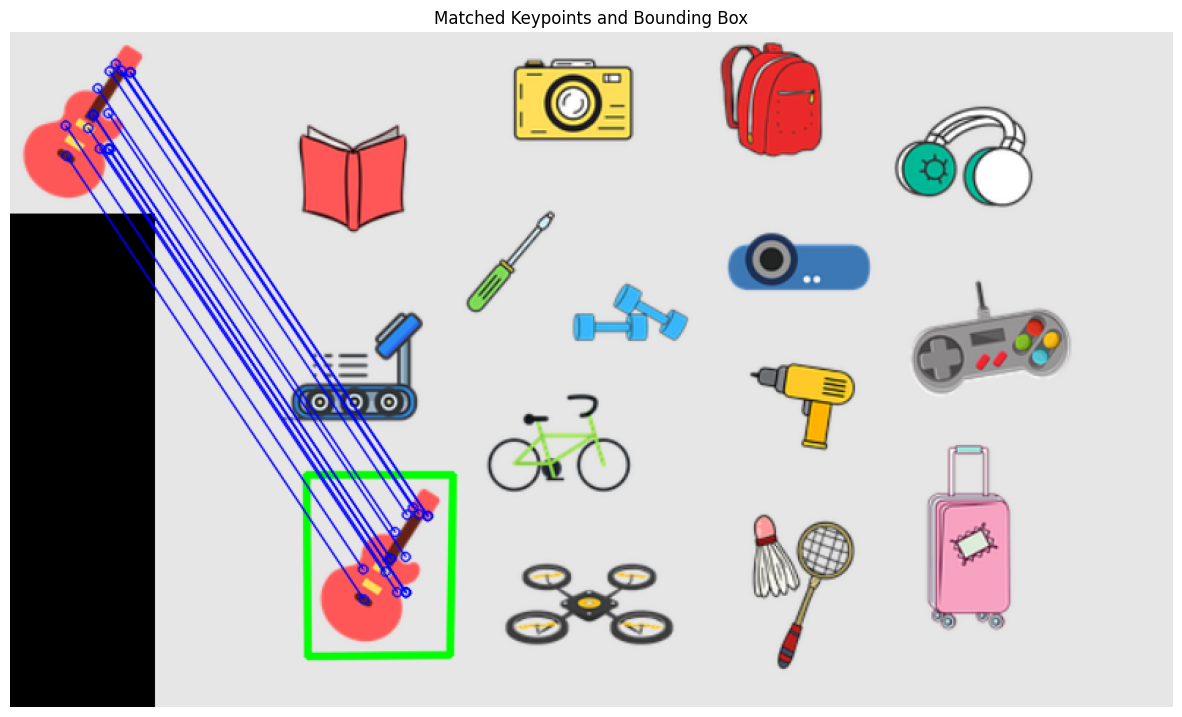

In [ ]:
# Step 6: Draw bounding box if enough matches are found
if len(good_matches) > 10:
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

    # Find homography
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    if M is not None:
        h, w = query_img_color.shape[:2]
        pts = np.float32([[0, 0], [0, h], [w, h], [w, 0]]).reshape(-1, 1, 2)
        dst = cv2.perspectiveTransform(pts, M)

        # Draw bounding box on target image
        target_boxed = target_img_color.copy()
        target_boxed = cv2.polylines(target_boxed, [np.int32(dst)], True, (0, 255, 0), 4, cv2.LINE_AA)

        # Draw matches
        result_img = cv2.drawMatches(query_img_color, kp1, target_boxed, kp2, good_matches, None,
                                     matchColor=(255, 0, 0), singlePointColor=None,
                                     matchesMask=mask.ravel().tolist(), flags=2)

        # Convert to RGB for display
        plt.figure(figsize=(15, 10))
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title("Matched Keypoints and Bounding Box")
        plt.axis('off')
        plt.show()
    else:
        print("Homography could not be computed.")
else:
    print("Not enough good matches to draw bounding box.")
